In [52]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [54]:
df = pd.read_csv('data_for_other_models_train.csv')
print(df.columns)
print(len(df.columns))

Index(['log_price', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bed_type', 'cancellation_policy', 'cleaning_fee',
       'host_identity_verified', 'host_response_rate', 'instant_bookable',
       'zipcode', 'bedrooms', 'beds', 'Waterfront', 'Washer / Dryer',
       'Pets allowed', 'Wireless Internet', 'Air conditioning',
       'Family/kid friendly', 'Dishwasher', 'Kitchen', 'Beachfront', 'Heating',
       'TV', 'Pool', 'num_years_hosting', 'distance_to_Times_Square',
       'distance_to_Empire_State_Building', 'distance_to_Statue_of_Liberty',
       'distance_to_Central_Park', 'distance_to_JFK_Airport'],
      dtype='object')
32


In [55]:
print(df['distance_to_Statue_of_Liberty'].head())

0    10.0
1    16.0
2     6.0
3    17.0
4     9.0
Name: distance_to_Statue_of_Liberty, dtype: float64


In [58]:
# NAIVE BAYES NETWORK CODE

import numpy as np

class NaiveBayesMultiClass:
    def __init__(self, alpha=1.0):  # Default smoothing
        self.alpha = alpha
        self.classes_log_probability = None
        self.features_log_likelihood = {}
        self.class_indices = {}
        self.value_mappings = {}  # Maps feature values to integers for each feature

    def compute_classes(self, y):
        unique_classes, counts = np.unique(y, return_counts=True)
        self.class_indices = {label: idx for idx, label in enumerate(unique_classes)}
        self.classes_log_probability = {c: np.log(count / len(y)) for c, count in zip(unique_classes, counts)}

    def compute_features(self, X, y):
        epsilon = 1e-8
        for f in range(X.shape[1]):
            self.features_log_likelihood[f] = {}
            self.value_mappings[f] = {}  # Mapping for each feature
            
            for c, c_index in self.class_indices.items():
                indices = np.where(y == c)[0]
                x_given_c = X[indices, f]

                # Create a value map for each unique value in this feature
                unique_values = np.unique(X[:, f])
                self.value_mappings[f] = {val: idx for idx, val in enumerate(unique_values)}

                # Store log likelihoods for each unique value
                likelihoods = []
                for val in unique_values:
                    prob = (np.sum(x_given_c == val) + self.alpha) / (len(x_given_c) + len(unique_values) * self.alpha)
                    likelihoods.append(np.log(prob+epsilon))
                
                # Store the mapped log likelihoods
                self.features_log_likelihood[f][c] = likelihoods

    def fit(self, X, y):
        self.compute_classes(y)
        self.compute_features(X, y)
        return self

    def joint_log_likelihood(self, X):
        n_samples = X.shape[0]
        joint_log_likelihood = np.zeros((n_samples, len(self.classes_log_probability)))
        
        for f in range(X.shape[1]):
            for i, x_val in enumerate(X[:, f]):
                for c, c_index in self.class_indices.items():
                    # Map x_val to an integer index if it exists in training mappings
                    x_val_index = self.value_mappings[f].get(x_val, None)
                    if x_val_index is not None:
                        joint_log_likelihood[i, c_index] += self.features_log_likelihood[f][c][x_val_index]
        
        # Add class prior probabilities
        for c, c_index in self.class_indices.items():
            joint_log_likelihood[:, c_index] += self.classes_log_probability[c]
        
        return joint_log_likelihood

    def predict(self, X):
        joint_log_likelihoods = self.joint_log_likelihood(X)
        return np.array([list(self.class_indices.keys())[i] for i in np.argmax(joint_log_likelihoods, axis=1)])

In [59]:
# Convert data into arrays
X = df.drop(columns=['log_price']).values  # 2D features array
y = df['log_price'].values  # 1D labels arra

naive_bayes = NaiveBayesMultiClass()

naive_bayes.fit(X, y)

y_pred = naive_bayes.predict(X)

accuracy = accuracy_score(y, y_pred)

print("Accuracy of the Naive Bayes Classifier on traning data: ", accuracy)
print("")
print("")
#END

Accuracy of the Naive Bayes Classifier on traning data:  0.7238157679069005




In [60]:
df_test = pd.read_csv('data_for_other_models_test.csv')

X_test = df_test.drop(columns=['log_price']).values  # 2D features array
y_test = df_test['log_price'].values  # 1D labels arra

y_pred = naive_bayes.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.7087020648967551


In [62]:
####### Look for uncorrolated vars #######

# PURPOSE:
    # - Ensure all columns have at least 2 unique values
    # - Find heavily corrolated vars to eliminate unneccessary vars
    # - NOTE: This only works for numeric data, not categorical data

In [64]:
# If nothing prints, it means all columns have at least 2 unique values
for col in df.columns:
    if df[col].nunique() == 1:
        print(f"Column '{col}' has only one unique value: {df[col].unique()[0]}")

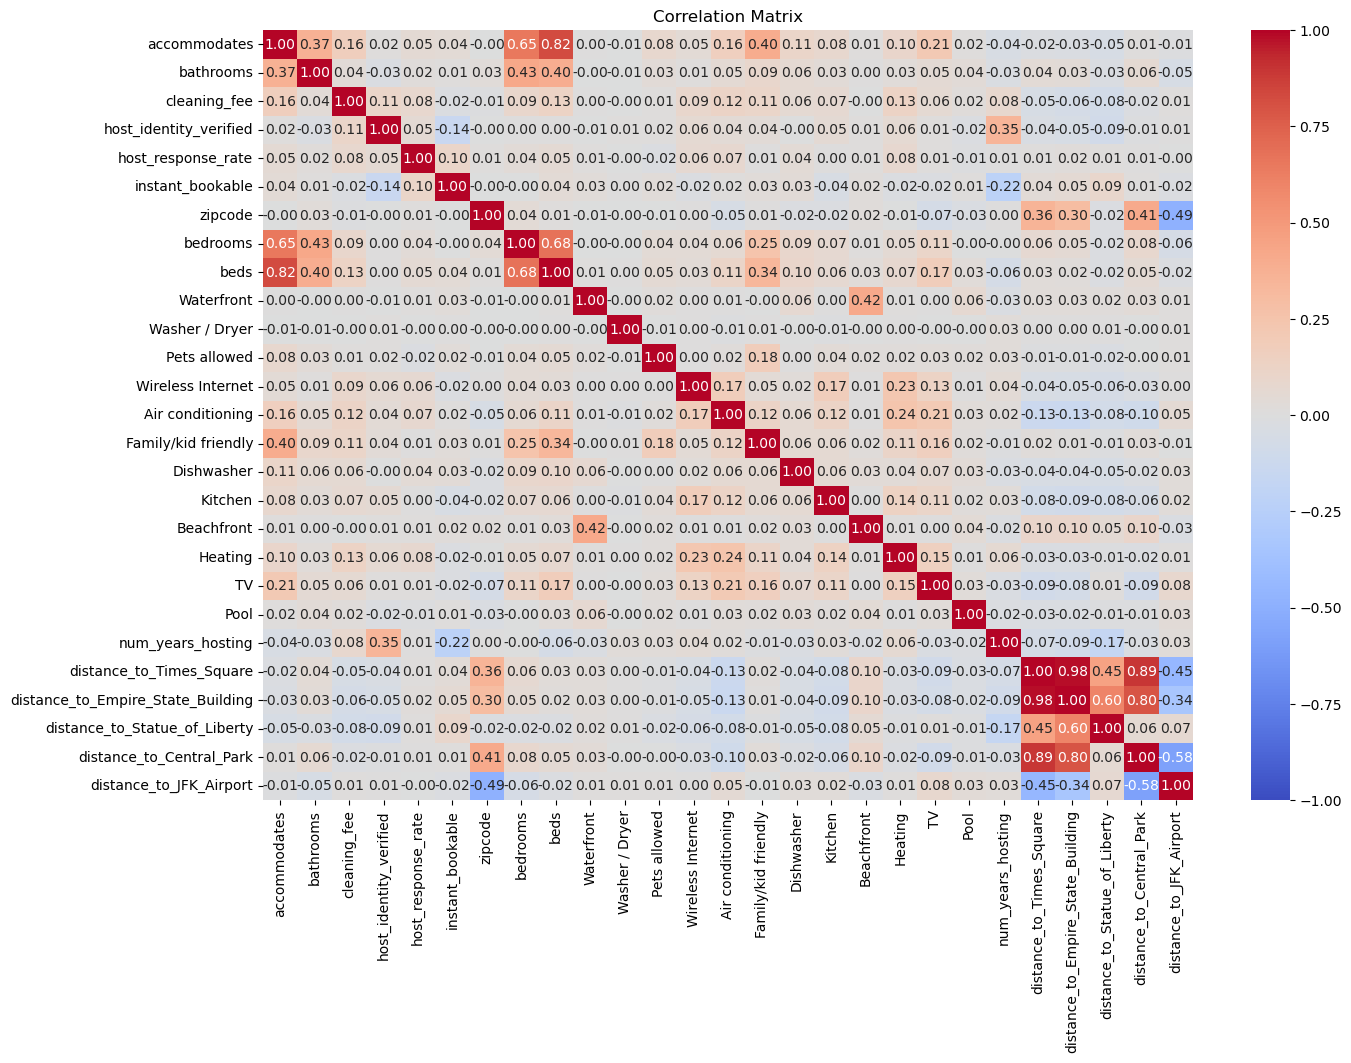

In [67]:
df_numeric = df.select_dtypes(include=[np.number])

correlation_matrix = df_numeric.corr()

# Display the correlation matrix
# print(correlation_matrix)

# Visualize it using a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

In [68]:
# Highly corrolated colums:
    # - 'accomodates' & 'beds'
    # - 'bedrooms' & 'beds'
    # - 'bedrooms' & 'accomodates'
    # - 'distance_to_Times_Square' & 'distance_to_empire_state_building'
    # - 'distance_to_Statue_of_liberty' & 'distance_to_empire_state_building'
    # - 'distance_to_Times_Square' & 'distance_to_central_park'
    # - 'distance_to_central_park' & 'distance_to_JFK_Airport'

# Medium corrolated colums:
    # - 'accomodates' & 'bathrooms'
    # - 'accomodates' & 'Family/kid friendly'
    # - 'distance_to_Times_Square' & 'waterfront'
    # - 'distance_to_Times_Square' & 'zipcode'
    # - 'distance_to_JFK_Airport' & 'zipcode'
    # - 'num_years_hosting' & 'host_identity_verified'
    # - 'waterfront' & 'beachfront'
    

# What to eliminate:
    # - 'beds'
    # - 'bedrooms'
    # - 'bathrooms'
    # - 'Family/kid friendly'
    # - 'distance_to_empire_state_building'
    # - 'distance_to_Statue_of_liberty'
    # - 'distance_to_central_park'
    # - 'waterfront'
    # - 'host_identity_verified'
    # - 'zipcode'
    # - 'distance_to_JFK_Airport'
    


# WHY:
    # - 'accomodates' describes everything 'beds', 'Family/kid friendly', 'bathrooms', and 'bedrooms' desribes, so those vars are unneccessary
    # - The most visited tourist attraction in NYC is Times Square, and thereofre it's the only distance we should keep
        #   SOURCE: https://en.wikipedia.org/wiki/Tourism_in_New_York_City#:~:text=Times%20Square%20is%20the%20hub,at%2060%20million%20including%20daytrippers.
    # - 'waterfront' and 'zipcode' are similar to distance measures, so we'll drop them
    # - 'host_identity_verified' is similar to 'num_years_hosting', so it can be dropped

In [69]:
# Only take neccessary columns
df_numeric = df_numeric[['accommodates', 'cleaning_fee',
       'host_response_rate', 'instant_bookable', 'Washer / Dryer', 'Pets allowed', 'Wireless Internet',
       'Air conditioning', 'Dishwasher', 'Kitchen',
       'Beachfront', 'Heating', 'TV', 'Pool', 'num_years_hosting',
       'distance_to_Times_Square']]

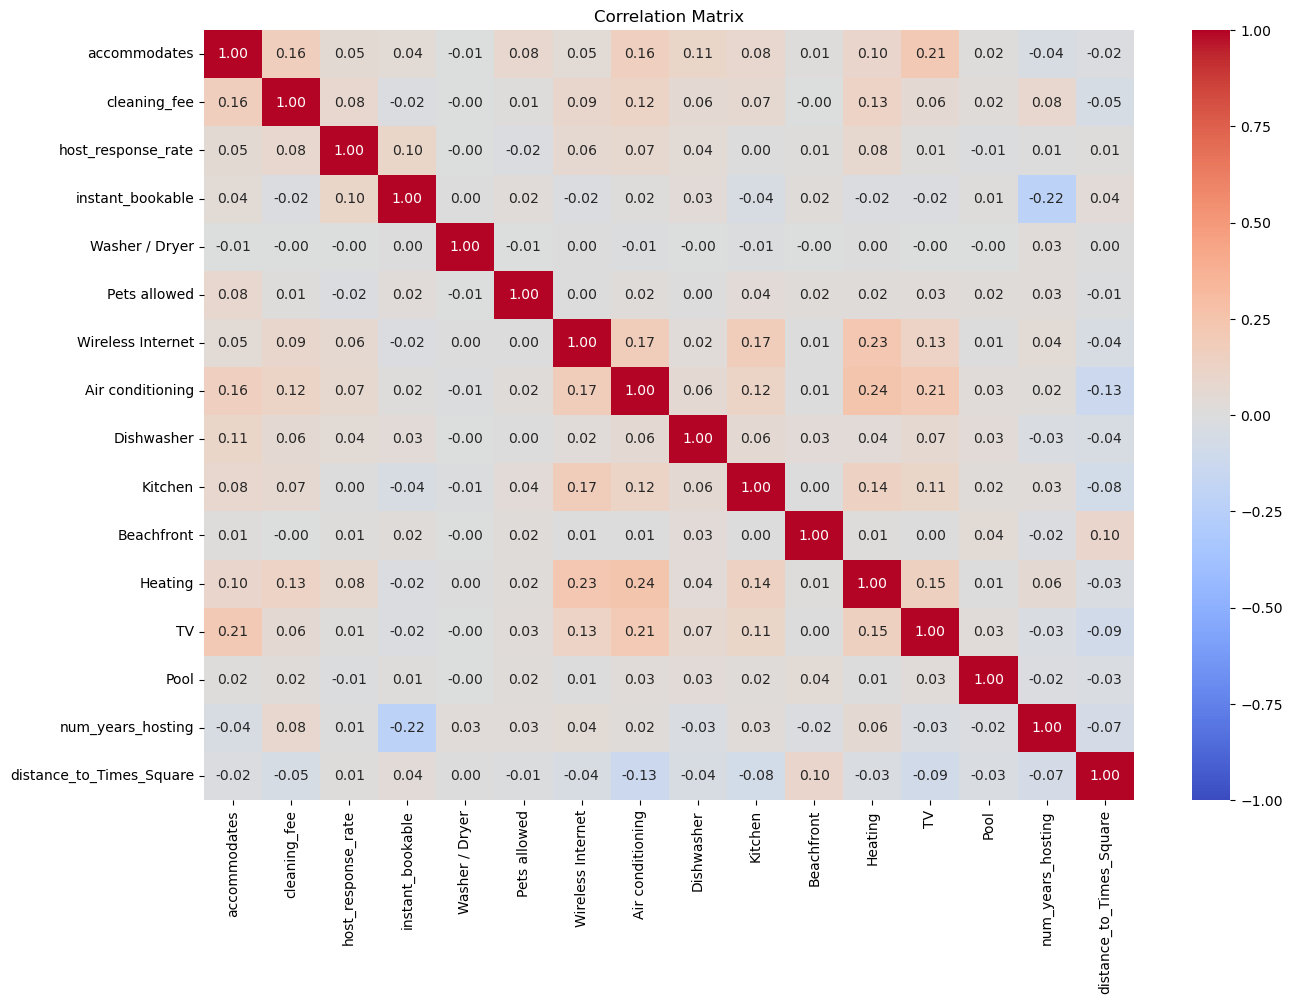

In [70]:
# RERUN Cor matrix to ensure no issues
correlation_matrix = df_numeric.corr()

# Display the correlation matrix
# print(correlation_matrix)

# Visualize it using a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

In [71]:
# Now, we retrain and test Naive Bayes with our new column set
df = df[['log_price', 'property_type', 'room_type', 'accommodates', 'cleaning_fee',
       'host_response_rate', 'instant_bookable','Washer / Dryer', 'Pets allowed', 'Wireless Internet',
       'Air conditioning','Dishwasher', 'Kitchen',
       'Beachfront', 'Heating', 'TV', 'Pool', 'num_years_hosting',
       'distance_to_Times_Square', 'bed_type', 'cancellation_policy']]

# We should expect 21, as we started with 32, and eliminated 11
print(len(df.columns))

21


In [72]:
df_train = pd.read_csv('data_for_other_models_train.csv')[['log_price', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bed_type', 'cancellation_policy', 'cleaning_fee',
       'host_identity_verified', 'host_response_rate', 'instant_bookable',
       'zipcode', 'bedrooms', 'beds', 'Waterfront', 'Washer / Dryer',
       'Pets allowed', 'Wireless Internet', 'Air conditioning',
       'Family/kid friendly', 'Dishwasher', 'Kitchen', 'Beachfront', 'Heating',
       'TV', 'Pool', 'num_years_hosting', 'distance_to_Times_Square',
       'distance_to_Empire_State_Building', 'distance_to_Statue_of_Liberty',
       'distance_to_Central_Park', 'distance_to_JFK_Airport']]

df_test = pd.read_csv('data_for_other_models_test.csv')[['log_price', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bed_type', 'cancellation_policy', 'cleaning_fee',
       'host_identity_verified', 'host_response_rate', 'instant_bookable',
       'zipcode', 'bedrooms', 'beds', 'Waterfront', 'Washer / Dryer',
       'Pets allowed', 'Wireless Internet', 'Air conditioning',
       'Family/kid friendly', 'Dishwasher', 'Kitchen', 'Beachfront', 'Heating',
       'TV', 'Pool', 'num_years_hosting', 'distance_to_Times_Square',
       'distance_to_Empire_State_Building', 'distance_to_Statue_of_Liberty',
       'distance_to_Central_Park', 'distance_to_JFK_Airport']]

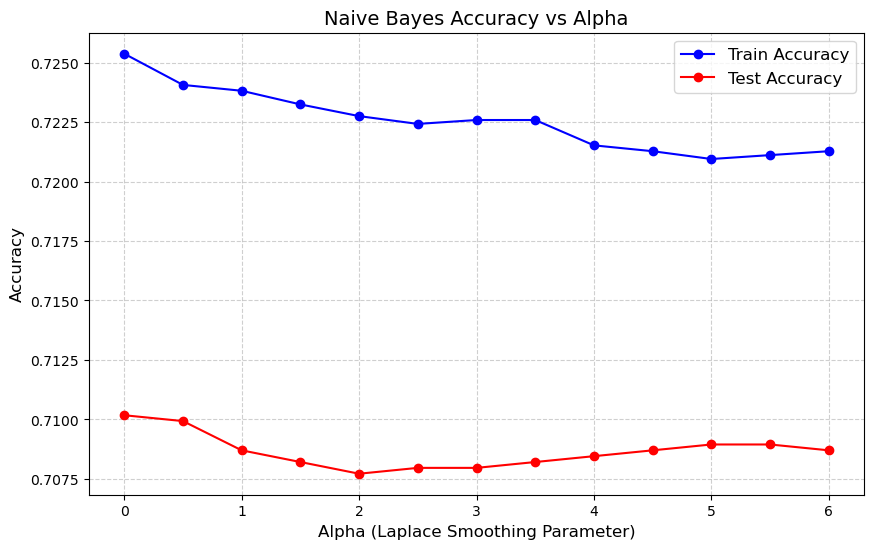

In [74]:
import matplotlib.pyplot as plt

# Convert data into arrays
X_train = df_train.drop(columns=['log_price']).values  # 2D features array
y_train = df_train['log_price'].values  # 1D labels arra

X_test = df_test.drop(columns=['log_price']).values  # 2D features array
y_test = df_test['log_price'].values  # 1D labels arra

alphas = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]
train_accuracies = []
test_accuracies = []

for a in alphas:
    naive_bayes = NaiveBayesMultiClass(alpha=a)
    
    naive_bayes.fit(X_train, y_train)
    
    y_pred_train = naive_bayes.predict(X_train)
    y_pred_test = naive_bayes.predict(X_test)
    
    train_accuracies.append(accuracy_score(y_train, y_pred_train))
    test_accuracies.append(accuracy_score(y_test, y_pred_test))

plt.figure(figsize=(10, 6))
plt.plot(alphas, train_accuracies, marker='o', linestyle='-', color='b', label='Train Accuracy')
plt.plot(alphas, test_accuracies, marker='o', linestyle='-', color='r', label='Test Accuracy')
plt.title('Naive Bayes Accuracy vs Alpha', fontsize=14)
plt.xlabel('Alpha (Laplace Smoothing Parameter)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.show()